In [178]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, basename
import pickle
from scipy.stats import pearsonr
from scipy.signal import periodogram, filtfilt
import seaborn as sns

from filtering import freq_filt

In [146]:
banner_coords = (44.3, -115.233)
res = pd.read_csv('/bsuscratch/zacharykeskinen/data/infrasound/eq_catalog/selected_v2.csv')
from shapely import wkt
res['geometry'] = res['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(res, geometry = 'geometry', crs = 'EPSG:4326')

data_dir = '/bsuscratch/zacharykeskinen/data/infrasound/array_data'
with open(join(data_dir, 'merged/all_days'), 'rb') as f:
    days = pickle.load(f)
sps = 200

In [150]:
n = 0
corr = pd.DataFrame()
for i, r in res[res.selected == 1].iterrows():
    dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
    day = days[dt]
    sig = {}
    s = pd.to_datetime(r.time)# + pd.Timedelta('4 second')
    e = s + pd.Timedelta('10 second')
    try:
        if 0.33 in day.keys() and 1.33 in day.keys() and day['snotel']['Snow Depth (cm) Start of Day Values'] > 133:
            for name, fp in day.items():
                if name != 'snotel':
                    sig[name] = freq_filt(pd.read_parquet(fp)[s:e].values.ravel(), 1, kind = 'highpass')
            df = pd.DataFrame(sig)
            df_corr = df.corr()
            if np.all(np.isnan(df_corr) == False):
                if corr.size == 0:
                    corr = df_corr
                else: 
                    corr += df_corr
                n += 1
            else:
                print(df_corr)
    except ValueError as e:
        print(dt)
        print(e)
corr /= n

2022-03-20
The length of the input vector x must be greater than padlen, which is 9.


Text(0.5, 1.0, 'Mean Correlation Between Sensors')

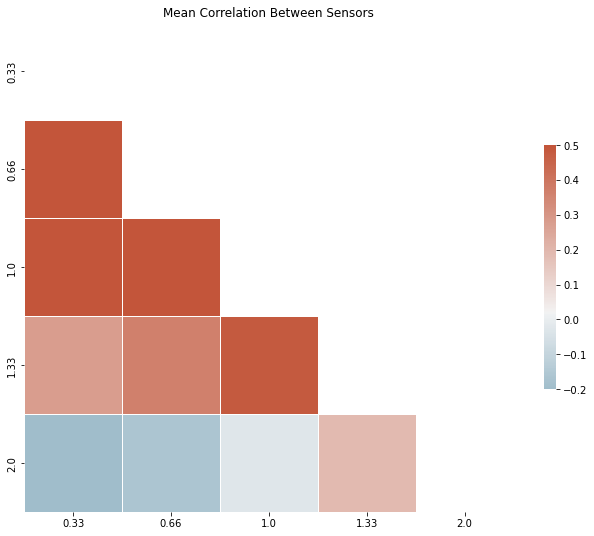

In [156]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=.02,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Mean Correlation Between Sensors')